# **Implementation of Balanced Risk Set Matching**

* Josef Hasm A. Agunod
* Sharly Pia Rose S. Barago



---



##**1. Data Preparation**

Let's start by simulating a dataset similar to the one described in the paper. Each patient has time-dependent measurements of symptoms (pain, urgency, nocturnal frequency) and a treatment time.

####**Import Libraries**

In [131]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns

####**Simulate Patient Data**

In [132]:
np.random.seed(42)

# Number of patients
n_patients = 200

# Patient IDs
patient_ids = np.arange(1, n_patients + 1)

# Entry times (uniformly distributed over 4 years)
entry_times = np.random.uniform(0, 48, size=n_patients)  # in months

# Treatment times (some patients receive treatment, others do not)
treatment_times = np.where(np.random.rand(n_patients) < 0.5,
                           np.random.uniform(0, 48, size=n_patients),
                           np.nan)  # NaN for untreated patients

# Simulate symptom scores (pain, urgency, frequency) at baseline and follow-ups
# Baseline scores
baseline_pain = np.random.randint(0, 10, size=n_patients)
baseline_urgency = np.random.randint(0, 10, size=n_patients)
baseline_frequency = np.random.randint(0, 10, size=n_patients)

# Follow-up scores (every 3 months for up to 4 years)
follow_ups = np.arange(3, 49, 3)  # 3, 6, 9, ..., 48 months

# DataFrame to store the data
data = pd.DataFrame({
    'patient_id': patient_ids,
    'entry_time': entry_times,
    'treatment_time': treatment_times,
    'baseline_pain': baseline_pain,
    'baseline_urgency': baseline_urgency,
    'baseline_frequency': baseline_frequency
})

# Follow-up symptom scores
for month in follow_ups:
    data[f'pain_{month}'] = baseline_pain + np.random.normal(0, 1, size=n_patients)
    data[f'urgency_{month}'] = baseline_urgency + np.random.normal(0, 1, size=n_patients)
    data[f'frequency_{month}'] = baseline_frequency + np.random.normal(0, 1, size=n_patients)

####**Display Data Sample**

In [133]:
# Display the first few rows of the dataset
print(data.head())

   patient_id  entry_time  treatment_time  baseline_pain  baseline_urgency  \
0           1   17.977926             NaN              4                 6   
1           2   45.634287       43.322540              1                 2   
2           3   35.135709       24.252114              9                 7   
3           4   28.735607             NaN              5                 9   
4           5    7.488895             NaN              4                 3   

   baseline_frequency    pain_3  urgency_3  frequency_3    pain_6  ...  \
0                   3  3.490142   5.802047     3.239477  4.641687  ...   
1                   9 -1.484612   3.317278     8.217982  2.224627  ...   
2                   1  9.919828   7.401344     3.222696  8.416642  ...   
3                   2  5.313862  11.182507     0.762179  5.038592  ...   
4                   6  2.318180   2.630478     6.524363  5.455619  ...   

   frequency_39    pain_42  urgency_42  frequency_42   pain_45  urgency_45  \
0      3

##**2. Risk Set Matching**

Here, we’ll implement the risk set matching. For each treated patient, we’ll find a control patient who has a similar history of symptoms up to the time of treatment but has not yet received treatment.

In [134]:
# Function to calculate Mahalanobis distance
def calculate_mahalanobis(x, y, cov):
    diff = x - y
    return np.sqrt(np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))

# Calculate the covariance matrix for symptom scores
symptom_columns = ['baseline_pain', 'baseline_urgency', 'baseline_frequency']
for month in follow_ups:
    symptom_columns.extend([f'pain_{month}', f'urgency_{month}', f'frequency_{month}'])

cov_matrix = data[symptom_columns].cov()

# Initialization of a list to store matched pairs
matched_pairs = []

# Iterating over treated patients
for treated_idx, treated_row in data[data['treatment_time'].notna()].iterrows():
    treatment_time = treated_row['treatment_time']

    # Find potential controls (untreated patients who are still at risk)
    potential_controls = data[(data['treatment_time'].isna()) |
                              (data['treatment_time'] > treatment_time)]

    # Calculate Mahalanobis distance between treated and potential controls
    distances = []
    for control_idx, control_row in potential_controls.iterrows():
        # Extract symptom history up to treatment time
        treated_symptoms = treated_row[symptom_columns].values
        control_symptoms = control_row[symptom_columns].values

        # Calculate Mahalanobis distance
        distance = calculate_mahalanobis(treated_symptoms, control_symptoms, cov_matrix)
        distances.append((control_idx, distance))

    # Find the control with the smallest distance
    if distances:
        control_idx, min_distance = min(distances, key=lambda x: x[1])
        matched_pairs.append((treated_idx, control_idx, min_distance))

# Convert matched pairs to a DataFrame
matched_pairs_df = pd.DataFrame(matched_pairs, columns=['treated_id', 'control_id', 'distance'])


####**Display Data Sample**

In [135]:
# Display the first few matched pairs
print(matched_pairs_df.head())

   treated_id  control_id  distance
0           1         198  7.951895
1           2         170  7.536581
2           5          77  7.884172
3           6         129  7.830953
4           8         195  6.943306


##**3. Balancing Covariates**

Next, we’ll ensure that the marginal distributions of symptoms are balanced between treated and control groups. We’ll divide the symptom scores into quantiles and enforce balance.

In [136]:
# Function to balance covariates by quantiles
def balance_covariates(matched_pairs_df, data, symptom_columns, n_quantiles=3):
    for col in symptom_columns:
        # Divide the symptom scores into quantiles
        quantiles = np.percentile(data[col], np.linspace(0, 100, n_quantiles + 1))
        data[f'{col}_quantile'] = pd.cut(data[col], bins=quantiles, labels=False)

        # Check balance in matched pairs
        treated_quantiles = data.loc[matched_pairs_df['treated_id'], f'{col}_quantile']
        control_quantiles = data.loc[matched_pairs_df['control_id'], f'{col}_quantile']

        print(f"Balance for {col}:")
        print("Treated quantiles:", treated_quantiles.value_counts().sort_index())
        print("Control quantiles:", control_quantiles.value_counts().sort_index())

# Balance covariates for baseline symptoms
balance_covariates(matched_pairs_df, data, ['baseline_pain', 'baseline_urgency', 'baseline_frequency'])

Balance for baseline_pain:
Treated quantiles: baseline_pain_quantile
0.0    25
1.0    23
2.0    32
Name: count, dtype: int64
Control quantiles: baseline_pain_quantile
0.0    35
1.0    28
2.0    19
Name: count, dtype: int64
Balance for baseline_urgency:
Treated quantiles: baseline_urgency_quantile
0.0    27
1.0    27
2.0    21
Name: count, dtype: int64
Control quantiles: baseline_urgency_quantile
0.0    35
1.0    30
2.0    17
Name: count, dtype: int64
Balance for baseline_frequency:
Treated quantiles: baseline_frequency_quantile
0.0    21
1.0    32
2.0    27
Name: count, dtype: int64
Control quantiles: baseline_frequency_quantile
0.0    32
1.0    14
2.0    33
Name: count, dtype: int64


##**4. Sensitivity Analysis**

This is to assess the robustness of the results to hidden bias. We’ll vary the parameter Γ (gamma) and observe how the results change.

In [137]:
# Function to perform sensitivity analysis
def sensitivity_analysis(matched_pairs_df, gamma_values):
    for gamma in gamma_values:
        # Calculate the sensitivity bounds
        sensitivity_bound = np.exp(gamma)
        print(f"Sensitivity analysis for gamma = {gamma}:")
        print("Sensitivity bound:", sensitivity_bound)

# Perform sensitivity analysis for different gamma values
gamma_values = [1.0, 1.5, 2.0, 2.5, 3.0]
sensitivity_analysis(matched_pairs_df, gamma_values)

Sensitivity analysis for gamma = 1.0:
Sensitivity bound: 2.718281828459045
Sensitivity analysis for gamma = 1.5:
Sensitivity bound: 4.4816890703380645
Sensitivity analysis for gamma = 2.0:
Sensitivity bound: 7.38905609893065
Sensitivity analysis for gamma = 2.5:
Sensitivity bound: 12.182493960703473
Sensitivity analysis for gamma = 3.0:
Sensitivity bound: 20.085536923187668


##**5. Inference and Analysis**

Here, we'll compare the outcomes of treated and control patients using paired comparisons and the Wilcoxon signed-rank test.

In [138]:
# Function to compare outcomes between treated and control patients
def compare_outcomes(matched_pairs_df, data, outcome_column):
    treated_outcomes = data.loc[matched_pairs_df['treated_id'], outcome_column]
    control_outcomes = data.loc[matched_pairs_df['control_id'], outcome_column]

    # Perform Wilcoxon signed-rank test
    stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
    print(f"Wilcoxon signed-rank test for {outcome_column}:")
    print("Statistic:", stat)
    print("P-value:", p_value)

# Comparing outcomes for pain at 3 months
compare_outcomes(matched_pairs_df, data, 'pain_3')

Wilcoxon signed-rank test for pain_3:
Statistic: 1671.0
P-value: 0.0948726214512604


##**6. Visualization**

We’ll create boxplots to visually compare the distributions of symptoms between treated and control patients.

In [139]:

# Function to plot boxplots for treated vs. control outcomes
def plot_boxplots(matched_pairs_df, data, outcome_column):
    treated_outcomes = data.loc[matched_pairs_df['treated_id'], outcome_column]
    control_outcomes = data.loc[matched_pairs_df['control_id'], outcome_column]

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Group': ['Treated'] * len(treated_outcomes) + ['Control'] * len(control_outcomes),
        'Outcome': pd.concat([treated_outcomes, control_outcomes])
    })

    plt.figure(figsize=(8, 6))
    # Use the DataFrame for plotting and specify x and y
    sns.boxplot(data=plot_df, x='Group', y='Outcome',
                notch=True, patch_artist=True)
    plt.title(f'Boxplot of {outcome_column} for Treated vs. Control')
    plt.show()

#For Differences
def plot_boxplots_difference(matched_pairs_df, data, outcome_column, base_column):
    treated_outcomes = data.loc[matched_pairs_df['treated_id'], base_column] - data.loc[matched_pairs_df['treated_id'], outcome_column]
    control_outcomes = data.loc[matched_pairs_df['control_id'], base_column] - data.loc[matched_pairs_df['control_id'], outcome_column]

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Group': ['Treated'] * len(treated_outcomes) + ['Control'] * len(control_outcomes),
        'Outcome': pd.concat([treated_outcomes, control_outcomes])
    })

    plt.figure(figsize=(8, 6))
    # Use the DataFrame for plotting and specify x and y
    sns.boxplot(data=plot_df, x='Group', y='Outcome',
                notch=True, patch_artist=True)
    plt.title(f'Boxplot of {outcome_column} difference for Treated vs. Control')
    plt.show()

####**Pain Score**

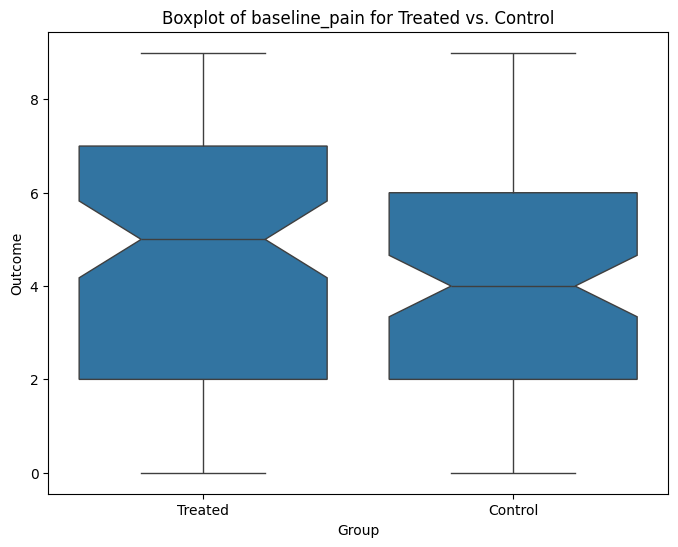

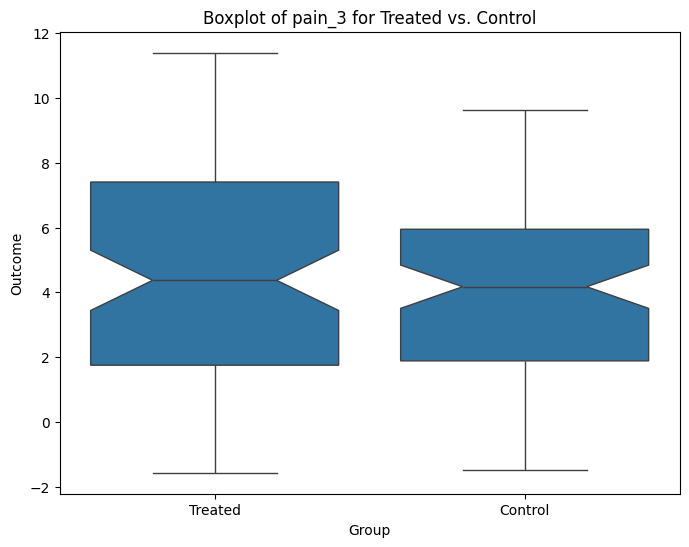

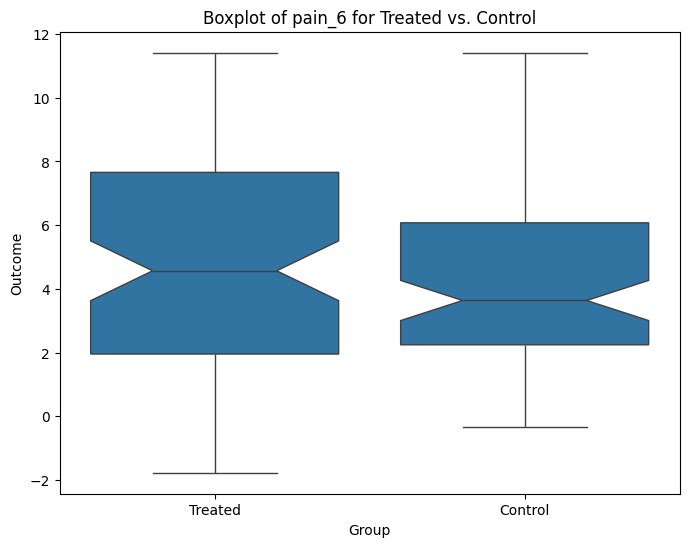

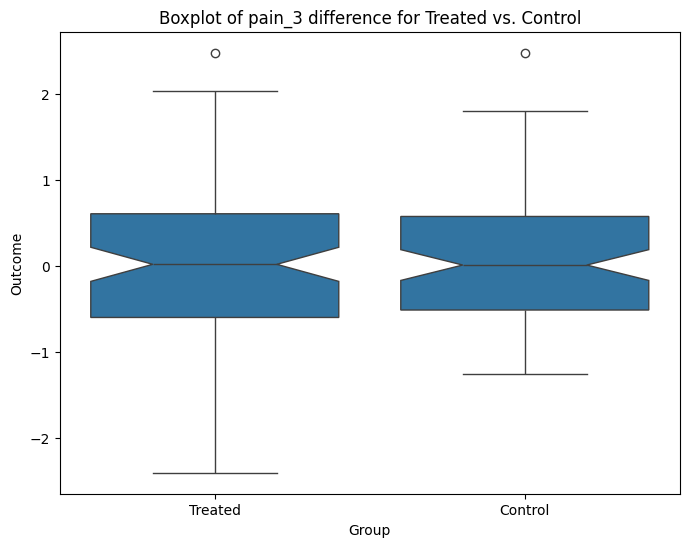

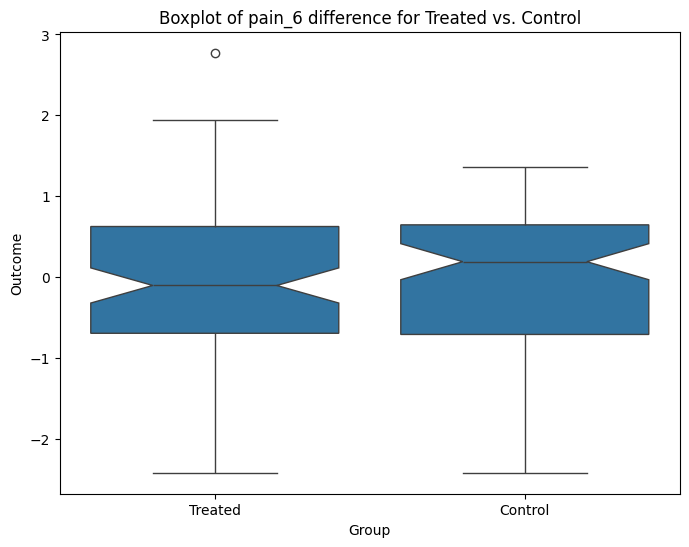

In [140]:
plot_boxplots(matched_pairs_df, data, 'baseline_pain')
plot_boxplots(matched_pairs_df, data, 'pain_3')
plot_boxplots(matched_pairs_df, data, 'pain_6')
plot_boxplots_difference(matched_pairs_df, data, 'pain_3', 'baseline_pain')
plot_boxplots_difference(matched_pairs_df, data, 'pain_6', 'baseline_pain')

####**Urgency Score**

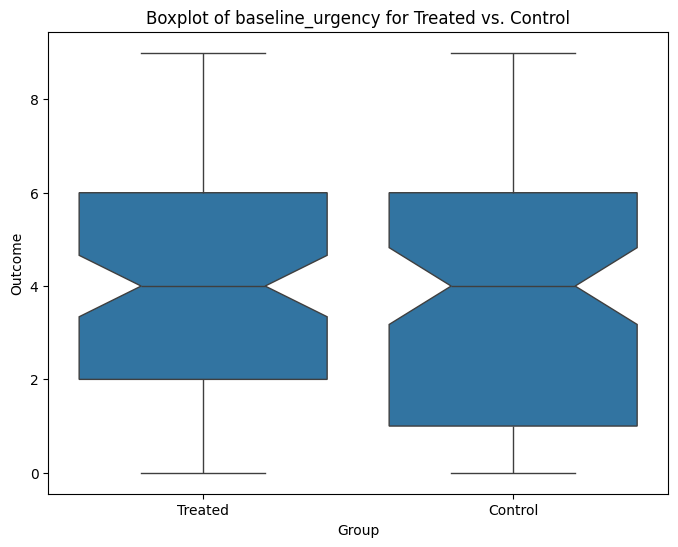

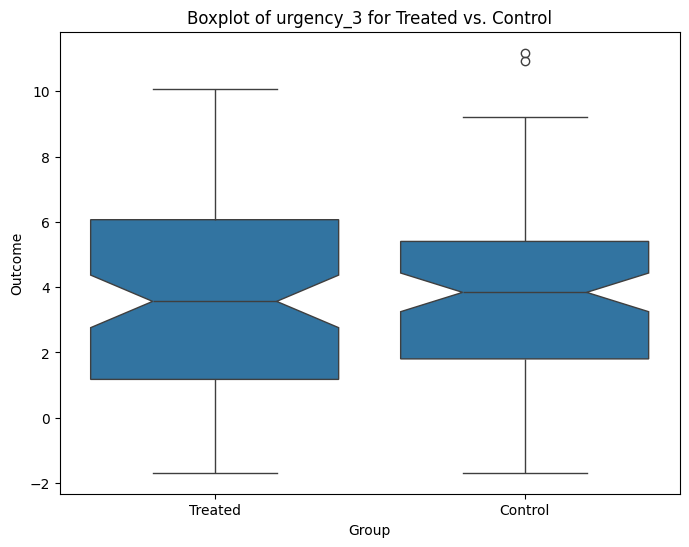

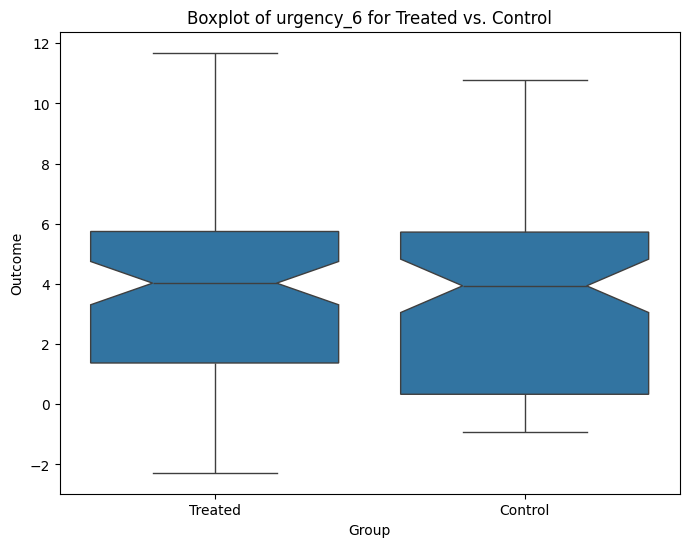

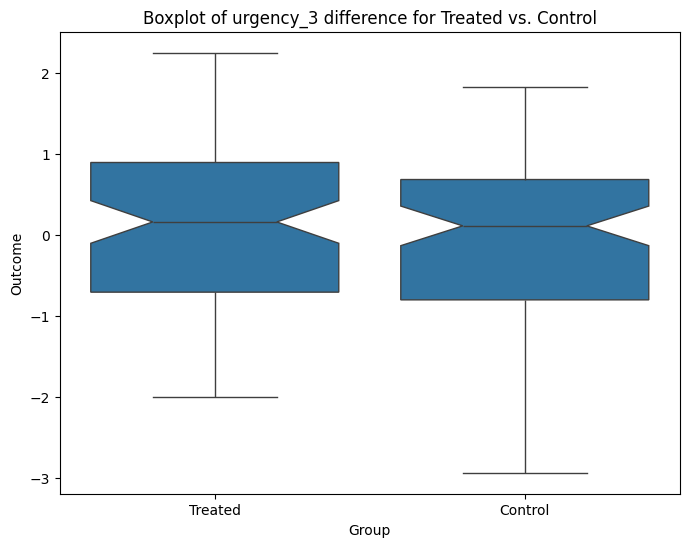

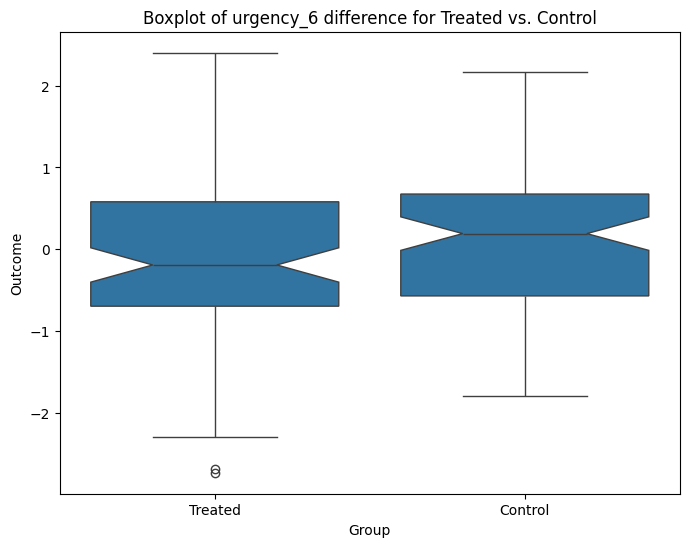

In [141]:
plot_boxplots(matched_pairs_df, data, 'baseline_urgency')
plot_boxplots(matched_pairs_df, data, 'urgency_3')
plot_boxplots(matched_pairs_df, data, 'urgency_6')
plot_boxplots_difference(matched_pairs_df, data, 'urgency_3', 'baseline_urgency')
plot_boxplots_difference(matched_pairs_df, data, 'urgency_6', 'baseline_urgency')

####**Nocturnal Frequency Score**

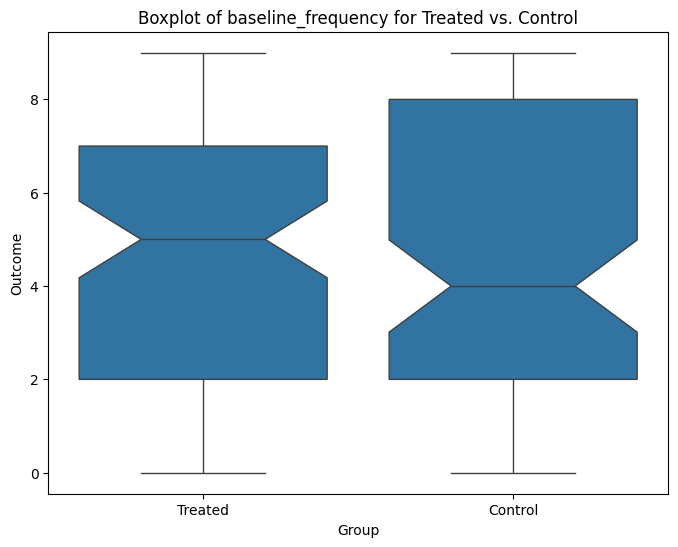

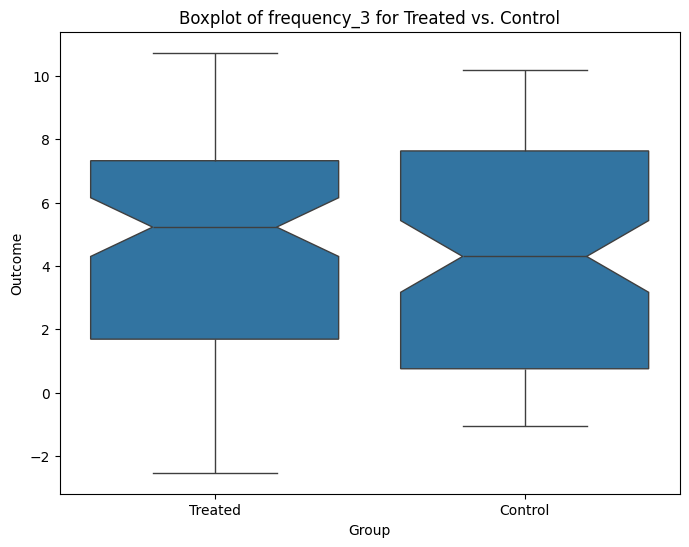

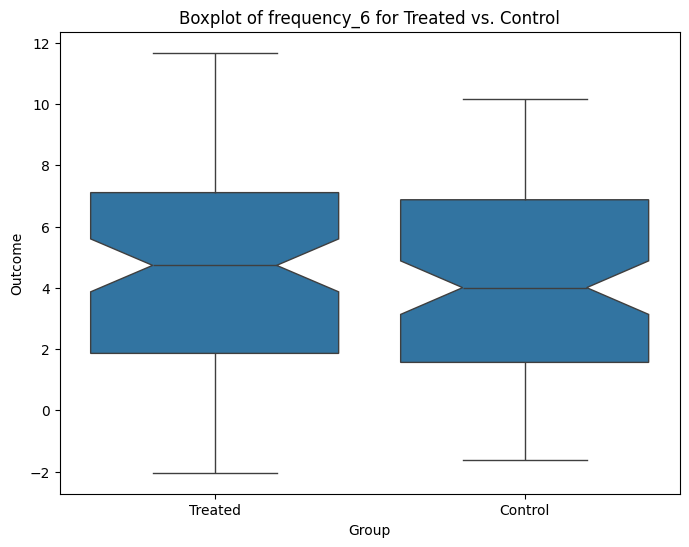

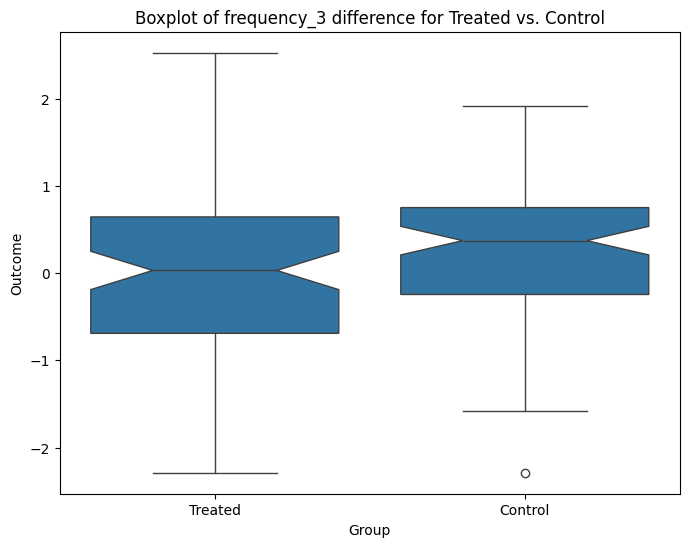

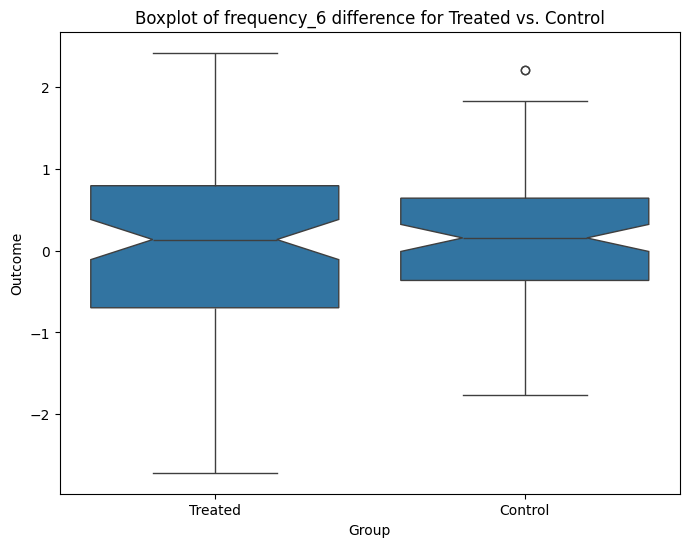

In [142]:
plot_boxplots(matched_pairs_df, data, 'baseline_frequency')
plot_boxplots(matched_pairs_df, data, 'frequency_3')
plot_boxplots(matched_pairs_df, data, 'frequency_6')
plot_boxplots_difference(matched_pairs_df, data, 'frequency_3', 'baseline_frequency')
plot_boxplots_difference(matched_pairs_df, data, 'frequency_6', 'baseline_frequency')